In [1]:
import numpy as np
import math
import time

import torch
import torch.nn as nn
import torch.optim as optim

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions

import importlib

param = 'JCPexample2'
use_cuda = torch.cuda.is_available()

In [2]:
if param=='DRLPDE_param_problem':
    DRLPDE_param = importlib.import_module("DRLPDE_param_problem")
    print("Pre-processing: Loading parameters from default location: DRLPDE_param_problem.py")
else:
    DRLPDE_param = importlib.import_module("." + param, package='examples')
    print("Pre-processing: Loading parameters from " + param + '.py')
    
### Use cuda
dev = torch.device("cuda:0" if use_cuda else "cpu")

### Unpack and organize variables related to the PDE problem 
boundingbox = DRLPDE_param.boundingbox
my_bdry = DRLPDE_param.my_bdry
pde_type = DRLPDE_param.pde_type
is_unsteady = DRLPDE_param.is_unsteady
output_dim = DRLPDE_param.output_dim

### TODO: Safeguard is_unsteady and pde_type
### 

### TODO: nn_type in DRLPDE_param_solver to choose the neural network
nn_param = {'depth': DRLPDE_param_solver.nn_depth,
            'width': DRLPDE_param_solver.nn_width,
            'x_dim':DRLPDE_param.x_dim,
            'is_unsteady':DRLPDE_param.is_unsteady ,
            'output_dim':DRLPDE_param.output_dim
            }

move_walkers_param={'x_dim': DRLPDE_param.x_dim,
                    'mu': DRLPDE_param.mu,
                    'dt': DRLPDE_param_solver.dt,
                    'num_batch': DRLPDE_param_solver.num_batch,
                    'num_ghost': DRLPDE_param_solver.num_ghost,
                    'tol': DRLPDE_param_solver.tol
                    }

eval_model_param={'dt': DRLPDE_param_solver.dt,
                    'forcing': DRLPDE_param.forcing}

### Import functions
if is_unsteady:
    # Include time range in bounding box
    boundingbox.append(DRLPDE_param.time_range)
    init_con = DRLPDE_param.init_con
    
    if pde_type == 'NavierStokes':
        move_Walkers = DRLPDE_functions.move_Walkers_NS_unsteady
    elif pde_type == 'Parabolic':
        move_Walkers = DRLPDE_functions.move_Walkers_Parabolic
    elif pde_type == 'StokesFlow':
        move_Walkers = DRLPDE_functions.move_Walkers_Stokes_unsteady
else:
    if pde_type == 'NavierStokes':
        move_Walkers = DRLPDE_functions.move_Walkers_NS_steady
    elif pde_type == 'Elliptic':
        move_Walkers = DRLPDE_functions.move_Walkers_Elliptic
    elif pde_type == 'StokesFlow':
        move_Walkers = DRLPDE_functions.move_Walkers_Stokes_steady

if pde_type == 'NavierStokes' or 'StokesFlow':
    evaluate_model = DRLPDE_functions.evaluate_model_NS
else:
    evaluate_model = DRLPDE_functions.evaluate_model_PDE
    
    move_walkers_param["drift"] = DRLPDE_param.drift
    eval_model_param["reaction"] = DRLPDE_param.reaction


num_walkers = DRLPDE_param_solver.num_walkers
num_ghost = DRLPDE_param_solver.num_ghost
num_batch = DRLPDE_param_solver.num_batch

update_walkers = DRLPDE_param_solver.update_walkers
update_walkers_every = DRLPDE_param_solver.update_walkers_every

num_bdry = DRLPDE_param_solver.num_bdry
num_batch_bdry = DRLPDE_param_solver.num_batch_bdry

num_epoch = DRLPDE_param_solver.num_epoch
update_print_every = DRLPDE_param_solver.update_print_every

lambda_bell = DRLPDE_param_solver.lambda_bell
lambda_bdry = DRLPDE_param_solver.lambda_bdry

if is_unsteady:
    num_init = DRLPDE_param_solver.num_init
    num_batch_init = DRLPDE_param_solver.num_batch_init
    lambda_init = DRLPDE_param_solver.lambda_init


################ Preparing the model #################

print("Initializing the model")

# Make boundaries defining the domain
boundaries = DRLPDE_functions.make_boundaries(my_bdry)

if pde_type == 'NavierStokes' or 'StokesFlow':
    MyNeuralNetwork = DRLPDE_nn.IncompressibleNN
else:
    MyNeuralNetwork = DRLPDE_nn.FeedForwardNN

# Initialize Model

if DRLPDE_param.loadmodel:
    model = torch.load("savedmodels/" + DRLPDE_param.loadmodel + ".pt")
    print("Using model from savedmodels/" + DRLPDE_param.loadmodel + ".pt")
else:
    model = MyNeuralNetwork(**nn_param).to(dev)

mseloss = nn.MSELoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), 
                        lr=DRLPDE_param_solver.learning_rate, 
                        betas=DRLPDE_param_solver.adam_beta, 
                        weight_decay=DRLPDE_param_solver.weight_decay)

# Create Walkers and Boundary points 

RWalkers = DRLPDE_functions.Walker_Data(num_walkers, boundingbox, boundaries)
RWalkers_batch = torch.utils.data.DataLoader(RWalkers, batch_size=num_batch, shuffle=True)

if update_walkers == 'move':
    move_RWalkers = torch.zeros_like(RWalkers.location)

BPoints = DRLPDE_functions.Boundary_Data(num_bdry, boundingbox, boundaries, is_unsteady)
BPoints_batch = torch.utils.data.DataLoader(BPoints, batch_size=num_batch_bdry, shuffle=True)

if is_unsteady:
    InitPoints = DRLPDE_functions.Initial_Data(num_init, boundingbox, boundaries, init_con)
    InitPoints_batch = torch.utils.data.DataLoader(InitPoints, batch_size=num_batch_init, shuffle=True)


Pre-processing: Loading parameters from JCPexample2.py
Initializing the model


In [3]:
start_time = time.time()

for step in range(num_epoch):

    # Random Walkers - do in batches
    for Xold, index in RWalkers_batch:
        
        # Send to GPU and set requires grad flag
        Xold = Xold.to(dev).requires_grad_(True)

        # Move walkers
        Xnew, Uold, outside = move_Walkers(Xold, model, boundaries, **move_walkers_param)

        # Evaluate at new location and average
        Unew = evaluate_model(Xold, Xnew, model, **eval_model_param).reshape(num_ghost, 
                                                                             num_batch,
                                                                             output_dim).mean(0)
        
        

        # Calculate loss
        loss = lambda_bell*mseloss(Uold, Unew.detach())
        loss.backward()

        # If moving walkers
        if update_walkers == 'move':
            if any(outside):
                Xnew[:num_batch,:][outside,:] = DRLPDE_functions.generate_interior_points(torch.sum(outside), 
                                                                                            boundingbox,
                                                                                            boundaries).to(dev)
            move_RWalkers[index,:] = Xnew[:num_batch].detach().cpu()


    # Boundary Points - Do in batches
    for Xbdry, Ubtrue in BPoints_batch:
        Xbdry = Xbdry.to(dev).requires_grad_(True)
        Ubtrue = Ubtrue.to(dev)
        Ubdry = model(Xbdry)
        loss = lambda_bdry*mseloss(Ubdry, Ubtrue.detach())
        loss.backward()

    # Initial Points - Do in batches
    if is_unsteady:
        for Xinit, Uinit_true in InitPoints_batch:
            Xinit = Xinit.to(dev).requires_grad_(True)
            Uinit_true = Uinit_true.to(dev).detach()
            Uinit = model(Xinit)
            loss = lambda_bdry*mseloss(Uinit, Uinit_true)
            loss.backward()

    # Make optimization step
    optimizer.step()
    optimizer.zero_grad()

    # Update walkers

    if (step+1) % update_walkers_every == 0:
        if update_walkers == 'move':
            RWalkers.location = move_RWalkers
            RWalkers_Batch = torch.utils.data.DataLoader(RWalkers, batch_size=num_batch, shuffle=True)
        elif update_walkers == 'remake':
            RWalkers = DRLPDE_functions.Walker_Data(num_walkers, boundingbox, boundaries)
            RWalkers_Batch = torch.utils.data.DataLoader(RWalkers, batch_size=num_batch, shuffle=True)

    # Print statements
    if step == 0:
        print('No errors in first epoch: Training will continue')
    if (step+1) % update_print_every == 0:
        current_time = time.time()
        np.set_printoptions(precision=2)
        print('step = {0}/{1}, {2:2.3f} s/step, time-to-go:{3:2.0f}s'.format(
                step+1, num_epoch, (current_time - start_time) / (step + 1), 
            (current_time - start_time) / (step + 1) * (num_epoch - step - 1)))


Error: Canceled future for execute_request message before replies were done

In [ ]:
Xbdry.shape

torch.Size([128, 2])

In [4]:
X.requires_grad

True

In [5]:
X.requires_grad = False

In [19]:
X = []

In [20]:
if X:
    print('Sup')

Sup


8

Plotting now
Loading parameters from JCPexample1.py
Domain plot saved in plots/JCPexample1_domain.png
Model solution plot saved in plots/JCPexample1_model.png
Analytic solution plot saved in plots/JCPexample1_analytic.png
L2 error is 5.498e-02
Linf error is 2.937e-02


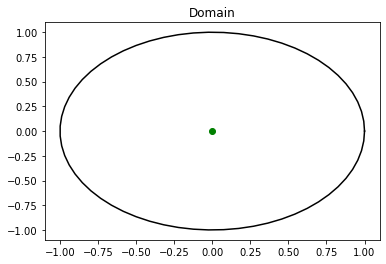

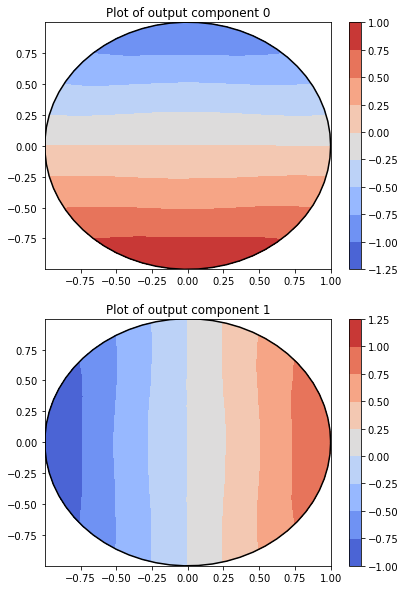

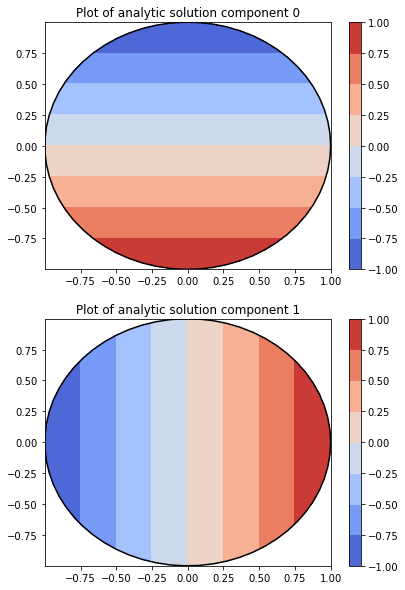